{'Invalid': 0, 'Valid': 1}


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

     Invalid       0.85      0.74      0.79       100
       Valid       0.77      0.87      0.82       100

    accuracy                           0.81       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.81      0.80       200



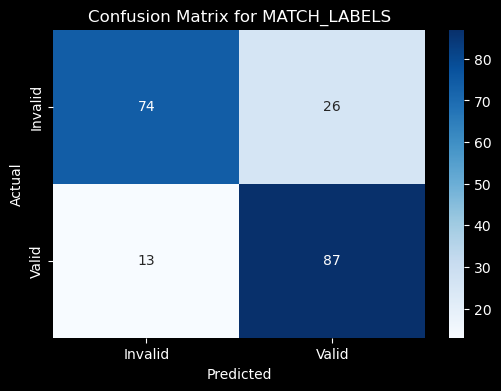

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from transformers import DistilBertModel
from transformers import BertTokenizer, BertForSequenceClassification, DataCollatorWithPadding
from transformers import LongformerTokenizerFast, LongformerForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification
import torch
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
import logging
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
from datetime import datetime
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
# Configure logging
# Load environment variables
from dotenv import load_dotenv
article_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/Deliverables/codes/Balanced_Main_Dataset3.csv')
seed = 42
article_df = article_df.sample(n=1000, random_state=42)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

le = LabelEncoder()
article_df['MATCH_LABELS_ENCODED'] = le.fit_transform(article_df['MATCH_LABELS'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)
class CustomOmissionClassifier(nn.Module):
    def __init__(self, pretrained_model_name="microsoft/deberta-v3-small", num_labels=2):
        super(CustomOmissionClassifier, self).__init__()
        self.omissionmodel = DebertaV2ForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=num_labels)
        # hidden_size = self.omissionmodel.config.hidden_size
        # self.classifier = nn.Linear(hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()


    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.omissionmodel(input_ids=input_ids, attention_mask=attention_mask)
        # last_hidden_state = outputs.last_hidden_state
        # pooled_output = last_hidden_state[:, 0]  # CLS token representation
        # logits = self.classifier(pooled_output)
        # Return a dict to mimic HF models
        return outputs.logits


model = CustomOmissionClassifier(num_labels=len(le.classes_))


# tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')
# model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096", num_labels=2, trust_remote_code=True)


# tokenizer = DistilBertTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BERTForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-small")



class BiasDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512, stride=64):
        # Add domains into the intiailization for classification
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        # self.stride = stride

        # self.samples = []
        # for text, label in zip(texts, labels):
        #     chunks = chunk_text(text, tokenizer, max_length, stride)
        #     for chunk in chunks:
        #         self.samples.append({
        #             'input_ids': chunk['input_ids'].squeeze(0),
        #             'attention_mask': chunk['attention_mask'].squeeze(0),
        #             'labels': torch.tensor(label, dtype=torch.long)
        #             })

    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        # return self.samples[idx]
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            add_special_tokens=True,
            return_attention_mask=True,
            padding=False,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


texts = (
    article_df['cleaned_content'].fillna('') + " "
    + article_df['entities_Group'].fillna('').astype(str) + " "
    + article_df['Actions'].fillna('').astype(str) + " "
    + article_df['Key_Phrases'].fillna('').astype(str)
).tolist()

labels = article_df['MATCH_LABELS_ENCODED'].tolist()

#text_size = len(texts)*0.9
#train_data = texts[: text_size]
#validation_data = texts[text_size:]

train_data, validation_data, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

train_labels_np = np.array(train_labels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_np),
    y=train_labels_np
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataset = BiasDataset(train_data, train_labels, tokenizer)
validation_dataset = BiasDataset(validation_data, validation_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True,collate_fn=data_collator, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=5, shuffle=False, collate_fn=data_collator, num_workers = 0)

model = CustomOmissionClassifier(num_labels=len(le.classes_))
model.load_state_dict(torch.load('/Users/amalkurian/Desktop/Dissertation/Bias Detection/models/DebertaV2/Deberta_final_model.pth', map_location=device))

# 2️⃣ Move to device & set eval mode
model.to(device)
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in validation_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1]  # positive class probability

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
auc_score = roc_auc_score(all_labels, all_probs)

# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
# plt.plot([0,1], [0,1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc='lower right')
# plt.show()
# Assuming you already have y_true and y_pred
all_preds = [1 if p >= 0.5 else 0 for p in all_probs]  # threshold = 0.5

# --------------------
# 2️⃣ Classification report
# --------------------
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# --------------------
# 3️⃣ Confusion Matrix
# --------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MATCH_LABELS")
plt.show()


Checkpoint loaded successfully with prefix adjustment.
AUC Score: 0.7745
Classification Report:
              precision    recall  f1-score   support

     Invalid       0.72      0.70      0.71       100
       Valid       0.71      0.73      0.72       100

    accuracy                           0.71       200
   macro avg       0.72      0.71      0.71       200
weighted avg       0.72      0.71      0.71       200



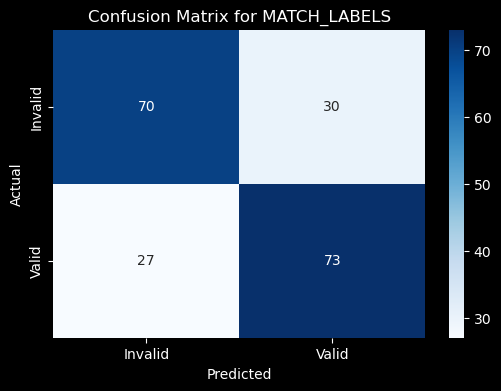

In [7]:
# ------------------------------
# 1️⃣ Load checkpoint safely
# ------------------------------
checkpoint_path = '/Users/amalkurian/Desktop/Dissertation/Bias Detection/models/DistilBERT/BERT.pth'
state_dict = torch.load(checkpoint_path, map_location=device)

# The keys in checkpoint are 'bert.xxx...' while your model expects 'omissionmodel.bert.xxx...'
# So we prepend 'omissionmodel.' to each key
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    new_key = f"omissionmodel.{k}"  # add prefix
    new_state_dict[new_key] = v

# Load the modified state_dict with strict=False
model.load_state_dict(new_state_dict, strict=False)
print("Checkpoint loaded successfully with prefix adjustment.")

# ------------------------------
# 2️⃣ Move model to device
# ------------------------------
model.to(device)
model.eval()

# ------------------------------
# 3️⃣ Validation loop
# ------------------------------
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in validation_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(logits, dim=1)[:, 1]  # positive class probability

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ------------------------------
# 4️⃣ ROC and AUC
# ------------------------------
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
auc_score = roc_auc_score(all_labels, all_probs)
print(f"AUC Score: {auc_score:.4f}")

# ------------------------------
# 5️⃣ Classification report
# ------------------------------
from sklearn.metrics import classification_report
all_preds = [1 if p >= 0.5 else 0 for p in all_probs]  # threshold = 0.5
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# ------------------------------
# 6️⃣ Confusion matrix
# ------------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MATCH_LABELS")
plt.show()


Label mapping: {'Invalid': 0, 'Valid': 1}
Accuracy: 0.865

Classification Report:
              precision    recall  f1-score   support

     Invalid       0.94      0.84      0.88       123
       Valid       0.78      0.91      0.84        77

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.88      0.86      0.87       200



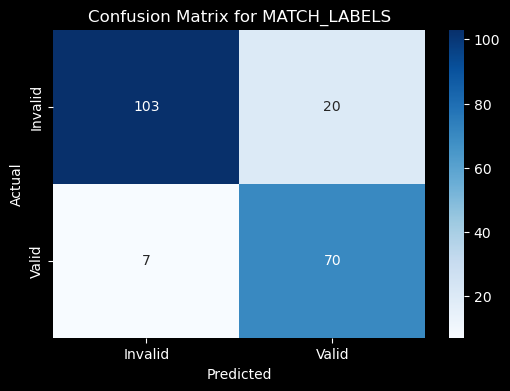

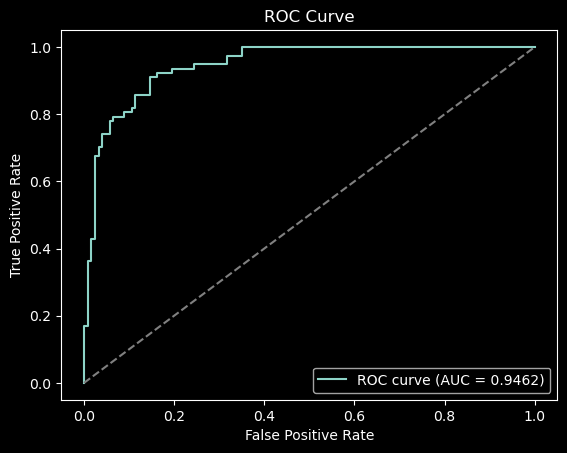

In [14]:
import joblib
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# -----------------------
# 1️⃣ Load data
# -----------------------
article_df = pd.read_csv('/Users/amalkurian/Desktop/Dissertation/Bias Detection/Deliverables/Main_Dataset1.csv')
article_df = article_df.sample(n=1000, random_state=42)
le = LabelEncoder()
article_df['MATCH_LABELS_ENCODED'] = le.fit_transform(article_df['MATCH_LABELS'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)

# Combine text features
texts = (
    article_df['cleaned_content'].fillna('') + " "
    + article_df['entities_Group'].fillna('').astype(str) + " "
    + article_df['Actions'].fillna('').astype(str) + " "
    + article_df['Key_Phrases'].fillna('').astype(str)
).tolist()
labels = article_df['MATCH_LABELS_ENCODED'].tolist()

# Split into train and validation sets (for evaluation)
_, val_data, _, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# -----------------------
# 2️⃣ Load your saved pipeline
# -----------------------
model_path = os.path.join(os.path.expanduser("~"), "Desktop/Dissertation/Bias Detection/models/DistilBERT/logistic_regression_model.pkl")
pipeline = joblib.load(model_path)

# -----------------------
# 3️⃣ Make predictions
# -----------------------
y_val = np.array(val_labels)
y_probs = pipeline.predict_proba(val_data)[:, 1]  # probability for positive class
y_preds = pipeline.predict(val_data)

# -----------------------
# 4️⃣ Metrics
# -----------------------
print("Accuracy:", accuracy_score(y_val, y_preds))
print("\nClassification Report:")
print(classification_report(y_val, y_preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_val, y_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MATCH_LABELS")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs, pos_label=1)
auc_score = roc_auc_score(y_val, y_probs)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
